In [93]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold, LeavePOut
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

In [94]:
os.listdir('../../')

['CompressedData', 'Images', 'Resultats', 'Scripts', 'Shapes']

## Get Rasters Informations, size, Geotransform... following one of the grid

In [95]:
#=================================================================
ClassifFolder = '../../Resultats/Classifications/'
ImagesFolder = '../../Images/Acolite/S2A_MSIL1C_20170929T231851_N0205_R001_T58KDE_20170929T231932/'
#=================================================================
raster_wavelength = ['560']
#=================================================================
raster_Name = ['Deglint/' + l + '.tif' for l in raster_wavelength]
#=================================================================
src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

1446 1644


## Define Rasters footprint

In [96]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.30822264582244, -18.607322034201378) 
Lower right corner :  (164.46445904649065, -18.477144404998807)


## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [97]:
# Select xml datafiles following common extent
RePath_xmlDirectory = '../../../Data_SHOM/Global'
#=================================================================
TimeThres = 1950
#=================================================================
#%timeit mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit mgp.GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)
print('Selected_xml :')
[print(xml) for xml in Selected_xml]
# Select xml datafiles following maximum depth
#=================================================================
Upto = 40
#=================================================================
Set , Count, failedXml = mgp.GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]

Selected_xml :
S199603800-1.object.xml


##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [98]:
# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, Set[1],integer=False)
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
#================================================================
TideHeight = 0.80 # Height of tide from SHOM website on Wadrilla Ouvea
#================================================================
depth=Set[2]
depth = depth[~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Number of point with negative depth : 0


## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifIndex.shape == Initial_Rasters.shape

(1446, 1644)


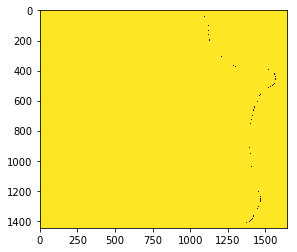

In [99]:
Lagoon = 'Mask/Lagoon.tif'

ClassifIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifIndex = ClassifIndex.GetRasterBand(1).ReadAsArray().astype(bool)
print(ClassifIndex.shape)
plt.imshow(ClassifIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [100]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
DictoDeph = {}
DictoPos = {}
for i in range(len(px)):
    Intpy, Intpx = int(py[i]),int(px[i])
    try:
        if ClassifIndex[Intpy, Intpx] == False: # Case for Poe int(px)
            continue
        SurveyIndex[Intpy, Intpx] += 1
        if SurveyIndex[Intpy, Intpx] == 1:
            DictoDeph[Intpy, Intpx] = []
            DictoPos[Intpy, Intpx] = []
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
        else:
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
    except:
        print(i)

## Compute Statistics on pixels containing measurements 

In [101]:
SurveyRatio = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyDisposition = {}
for i, j  in DictoDeph.keys():
    assert len(DictoPos[(i, j)]) == len(DictoDeph[(i, j)])
    Points = np.asarray(DictoPos[(i, j)])
    SurveyRatio[i, j], SurveyDisposition[i, j] = mgp.get_OccupiedRatio(Points[:,0], Points[:,1], radius=0.1)


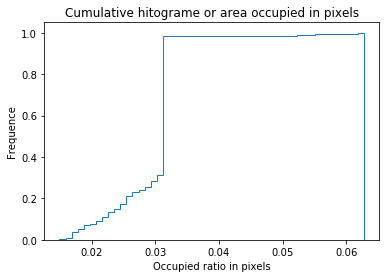

In [102]:
n, bins, patches = plt.hist(SurveyRatio[~np.isnan(SurveyRatio)], 50, histtype='step', cumulative=1, normed=True)
plt.xlabel('Occupied ratio in pixels')
plt.ylabel('Frequence')
plt.title('Cumulative hitograme or area occupied in pixels')


In [103]:
#=================================================================
CoverThreshold = 0.0313 # Filter pixel with only one measure at less than 1 meter of the border
#=================================================================
print('Nombre de Pixels Totale : {0:d}\nNombre de Pixels conservé: {1:d}'.format(np.sum(~np.isnan(SurveyRatio)),np.sum(SurveyRatio>CoverThreshold))) 

Nombre de Pixels Totale : 280
Nombre de Pixels conservé: 191


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in greater



In [104]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyIndex = np.full(ClassifIndex.shape, False, dtype=np.bool_)
PixMethod = ['nearest', 'linear']
PixMethodIndex = 0

rows, cols = np.where(SurveyRatio>CoverThreshold)
for i, j  in zip(rows,cols):
    Points = np.asarray(DictoPos[(i, j)])
    SurveyValues[i, j] = mgp.InterpPixDepth(Points, 
                                            DictoDeph[i, j], 
                                            modes=[PixMethod[PixMethodIndex]], 
                                            PlotArg=False)[0]
    SurveyIndex[i, j] = True

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in greater



## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [105]:
# Load Data at reduce backup size
#================================================================
RatiosId = 0
#================================================================
RatioType = ['Done','Raw']
RatioPath = ['../../CompressedData/SRXData.npz','../../CompressedData/SRXData_Raw.npz']
npzfile = np.load(RatioPath[RatiosId])
Xc = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)
RatiosKeys = npzfile['Keys'] # Keys defining order of recorded ratios 

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, Xc.shape[2]), np.nan) # Final array of optical data at Raster size 
ValidMap = np.full((RasterHeight, RasterWidth), False) # Map of area of Interest -> cropped area reducing backup size

# Translation of the data at the suitable dimension
X = Xc[:,:,:]
ValidMap = True
del Xc

# Useless here...
ToclassifyIndex = np.logical_and(ValidMap,ClassifIndex)
X.shape

(1446, 1644, 10)

## Special case in Poe, Area of interest for specific calibration manually created

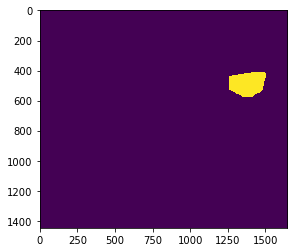

In [106]:
ShapeFolder = '../../Shapes/'
RoiPathName = ['Lagoon.shp']
#================================================================
Roidescription = ['Eau du lagon de Pétrie et de l''ocean ouvert au abord de celui-ci. Points de calibration du SHOM, tous situes a l''interieur du lagon.']
CalibZoIndex = 0
#================================================================

ResctictedLagoon = mgp.create_mask_from_vector(ShapeFolder + RoiPathName[CalibZoIndex], RasterWidth, RasterHeight, GT_ds, proj, target_value=1, format=gdal.GDT_Byte)
ResctictedLagoon = ResctictedLagoon.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(ResctictedLagoon)

## Visual check !

Nombre de pixel comportant une mesure immergées: 191


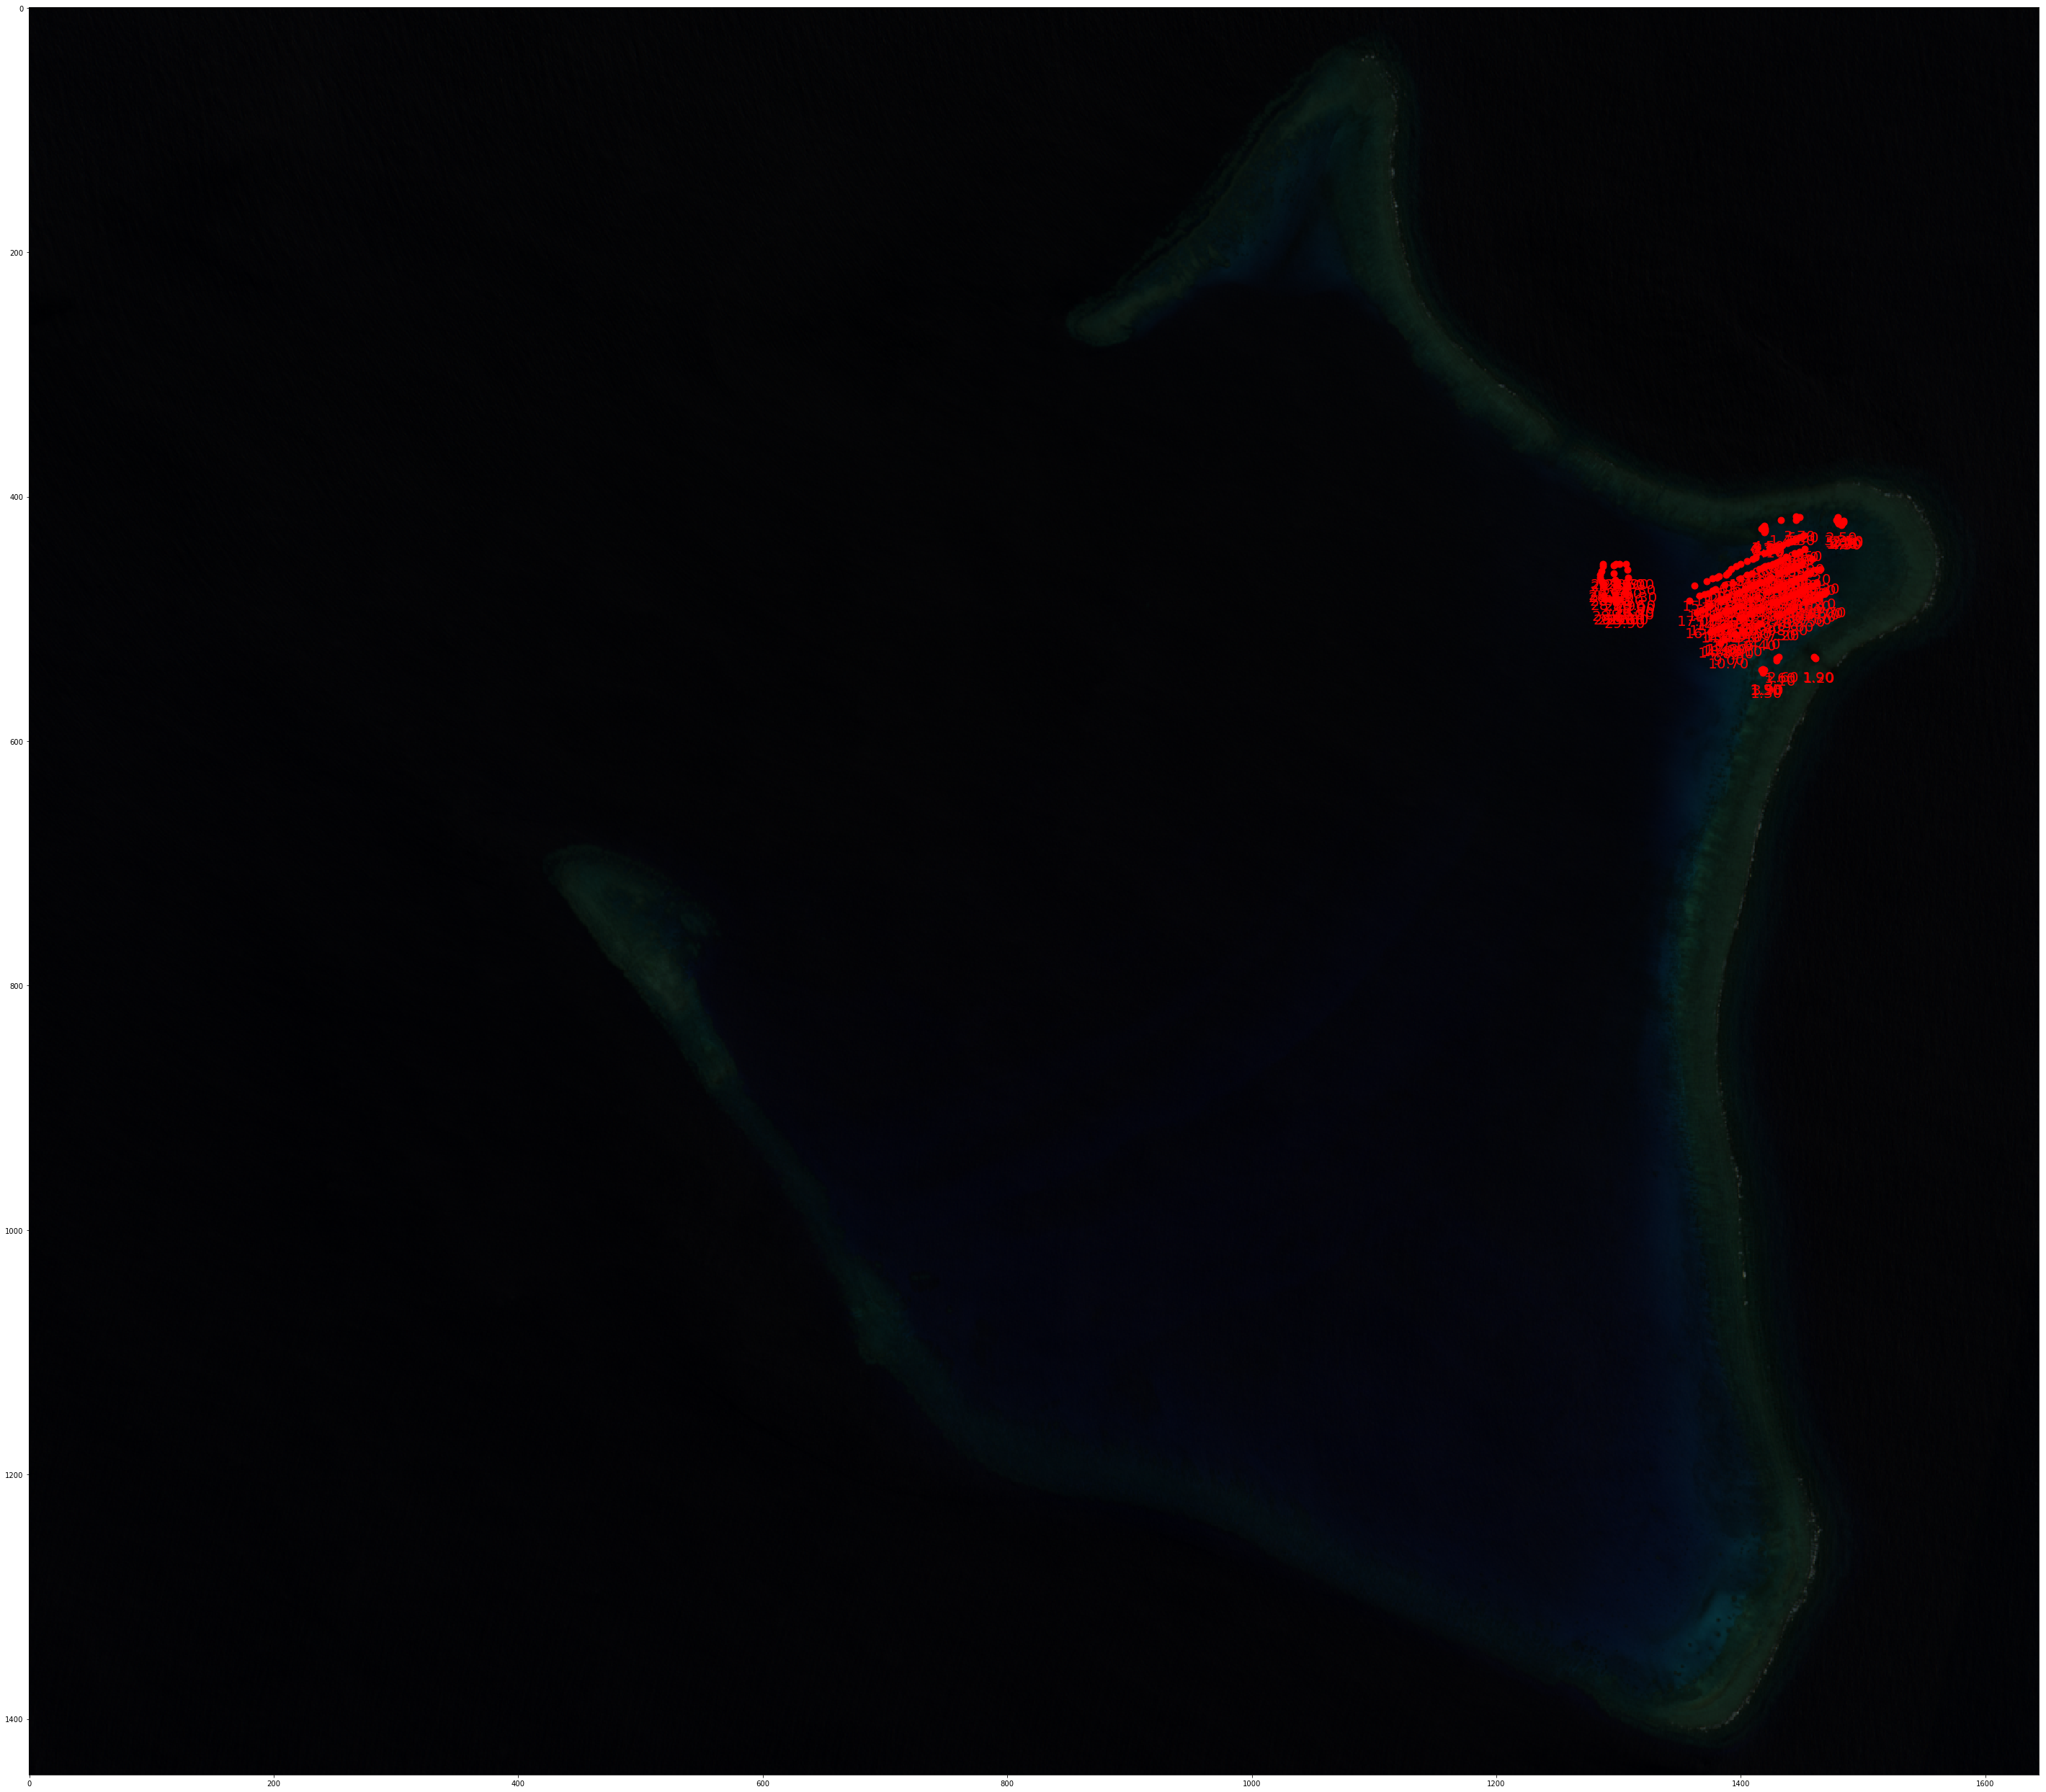

In [107]:
RGB_wavelength = ['492','560', '665']
Composite_Names = [ 'S2A_MSI_2017_09_29_23_18_51_T58KDE_rhos_' +l+ '.tif' for l in RGB_wavelength]
#Composite_Names = [ 'Deglint/' +l+ '.tif' for l in RGB_wavelength]

RGB = [mgp.GetSparseCrop(ImagesFolder+rbgBand,(RasterHeight, RasterWidth), 0, 0, RasterWidth, RasterHeight)  for rbgBand in Composite_Names]
VisRGB = np.dstack(RGB)
del RGB

# Manual cropping for better visual rendering
ScatterIndex = np.logical_and(ResctictedLagoon,SurveyIndex)
CroppedDepth = SurveyValues # Average deph of pixels contained in the visual cropped

# Scatter coordinates and image in rendered dimension
x,y = np.where(ScatterIndex)

Im = VisRGB[:,:,np.array([2,1,0])]

# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(Im)
plt.scatter(y,x,s=80, c='r')
for i in range(len(x)):
    ax.annotate('{0:.2f}'.format(CroppedDepth[ScatterIndex][i]), (y[i]-10,x[i]+20), color='red', size=20)
print("Nombre de pixel comportant une mesure immergées:",len(x))
del Im

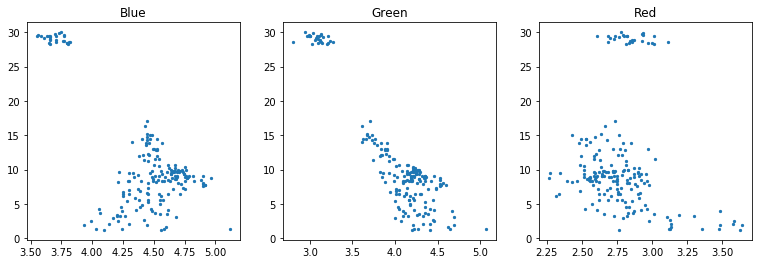

In [108]:
fig, ax = plt.subplots(1,3, figsize=(13,4))
Bname = ['Blue', 'Green', 'Red']
for i, axe in enumerate(fig.axes):
    axe.set_title(Bname[i])
    axe.scatter(np.log(1000*VisRGB[ScatterIndex,i]),CroppedDepth[ScatterIndex], s=5)

## Creation of calibration dataset

In [109]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex>0) # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [110]:
del X

In [111]:
invalidCalibValue = np.sum(np.isnan(Data_x),axis=1)>0
Data_x, Data_y = Data_x[~invalidCalibValue,:], Data_y[~invalidCalibValue]
print('Number of invalid calibration values : ', np.sum(invalidCalibValue)) 

Number of invalid calibration values :  28


In [112]:
ind[np.where(ind)[0][invalidCalibValue],np.where(ind)[1][invalidCalibValue]]=False

## exploratory statistics

['Red' 'ExtraRed'] correlation :  0.184932067351
['Green' 'ExtraRed'] correlation :  -0.253929472973
['Blue' 'ExtraRed'] correlation :  0.0521447103122
['ExtraBlue' 'ExtraRed'] correlation :  0.147312141055
['Green' 'Red'] correlation :  -0.583446685953
['Blue' 'Red'] correlation :  -0.144016335709
['ExtraBlue' 'Red'] correlation :  0.000214427154253
['Blue' 'Green'] correlation :  0.915667406645
['ExtraBlue' 'Green'] correlation :  0.946025209637
['ExtraBlue' 'Blue'] correlation :  0.677202330607


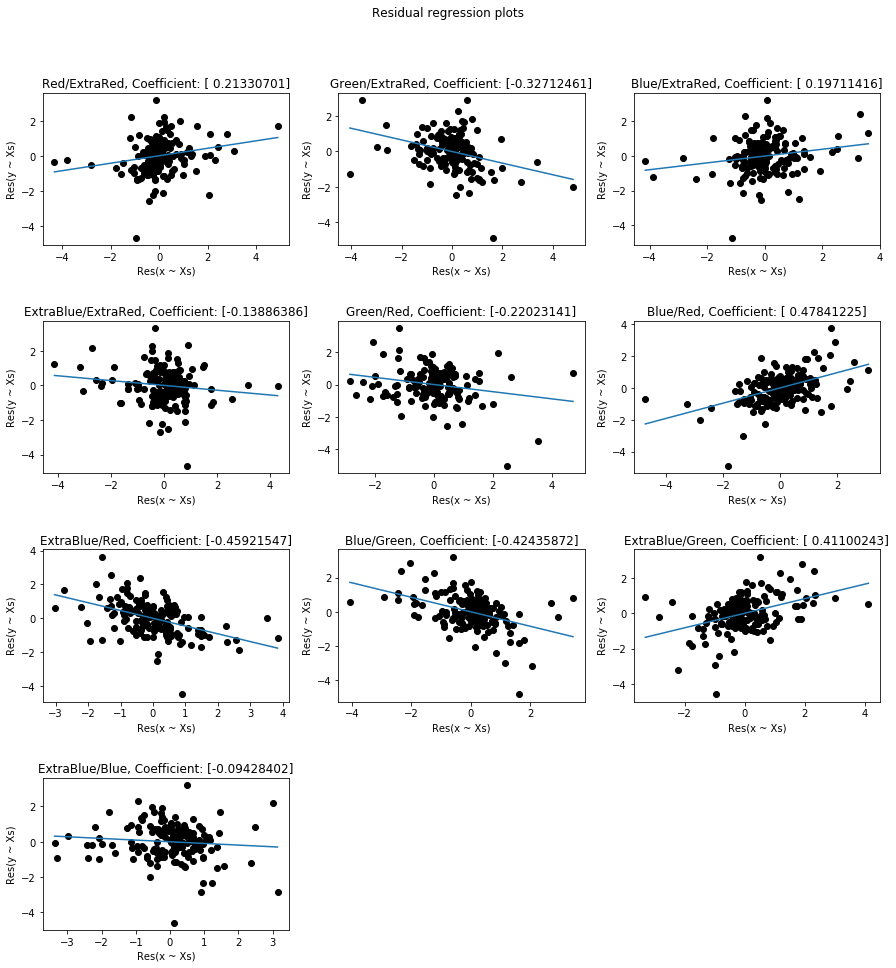

In [113]:
for i in range(Data_x.shape[1]):
    print(str(RatiosKeys[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=True, Titles=[str(i)+'/'+str(j) for i,j in RatiosKeys])

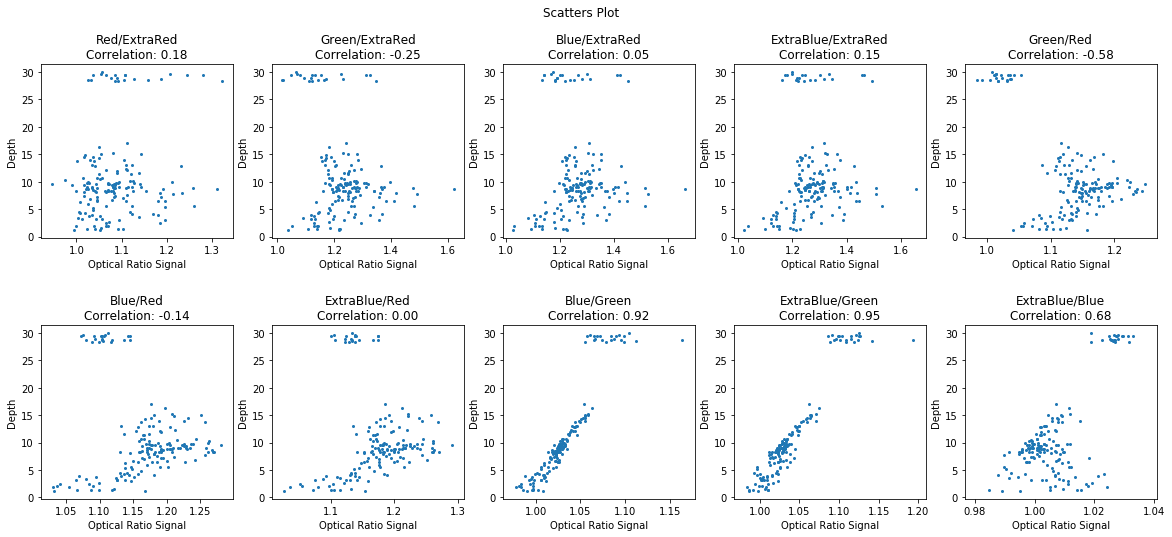

In [114]:
fig, axes = plt.subplots(2,5, figsize=(20, 8))
fig.suptitle('Scatters Plot')
fig.subplots_adjust(hspace=.5, top=.88)
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=4)
    ax.set_title(RatiosKeys[i][0]+'/'+RatiosKeys[i][1]+'\nCorrelation: {0:0.2f}'.format(np.corrcoef(Data_x[:,i],Data_y)[0,1]))
    ax.set_ylabel('Depth')
    ax.set_xlabel('Optical Ratio Signal')

In [115]:
x = Data_x
y = Data_y

# Simple linear Regression (Stumpf)

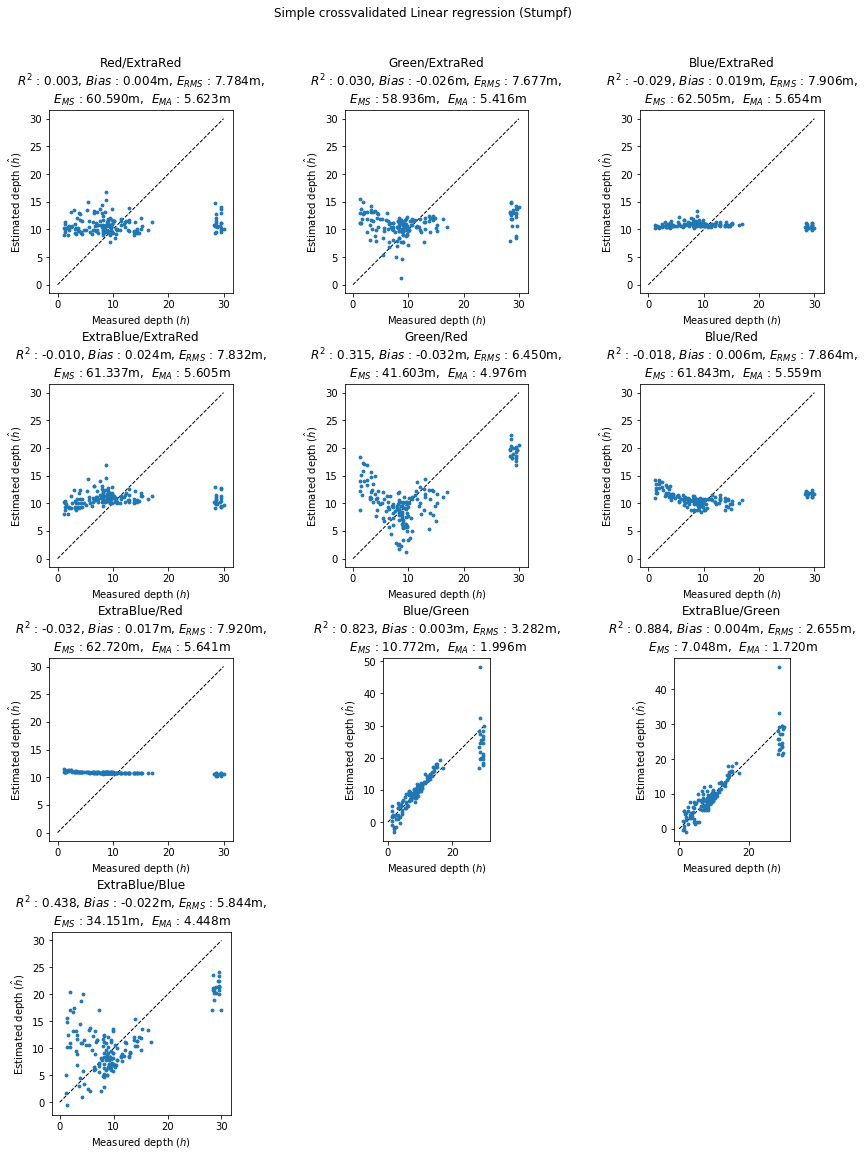

In [116]:
plotsPerRows = 3
fig , axes = plt.subplots(int(np.ceil(x.shape[1]/plotsPerRows)),plotsPerRows, figsize=(15,18))
fig.suptitle('Simple crossvalidated Linear regression (Stumpf)')
fig.subplots_adjust(hspace=.5, top=.9)
Outputs = []

for i, ax in enumerate(fig.axes):
    if i >= x.shape[1]:
        ax.set_visible(False)
        continue
    Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), x[:,i].reshape(-1,1), y, ax=ax, SetTitles= True, Titles=RatiosKeys[i][0]+'/'+RatiosKeys[i][1], spliting=KFold, ArgSplit={'n_splits':100}))
plt.show()

# Simple Multi-linear Regression (Stumpf)

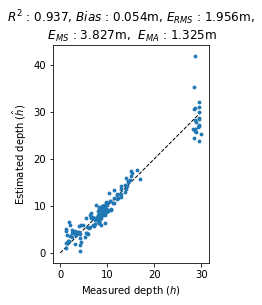

In [117]:
Outputs = []

Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), x, y))


# 2 Iterations Simple Multi-linear Regression (Stumpf)

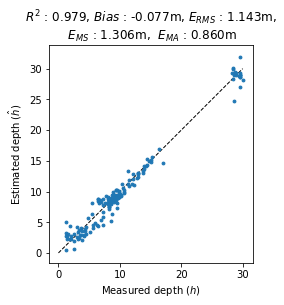

In [118]:
lr = mgp.my_2IterationsModel(linear_model.LinearRegression, [6,23])
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y))

# Multi-linear : Ridge Regression

Best RMS : 1.294 with alpha = exp(-5.52)
Best R2 : 0.935 with alpha = exp(-6.00)



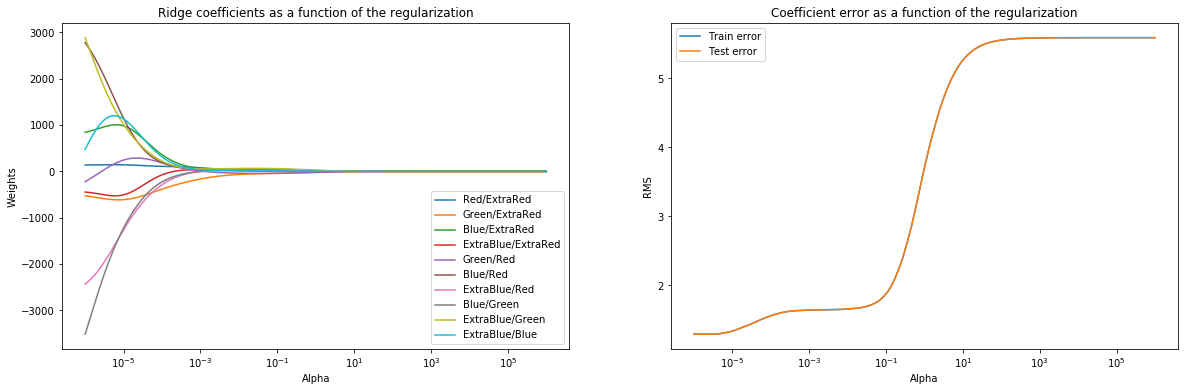

In [119]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Ridge(alpha=a)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['MAE'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_MAE'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Ridge coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[1].plot(alphas, tr_RMS, label='Train error')
ax[1].plot(alphas, RMS, label='Test error')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

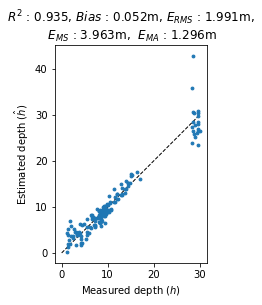

In [120]:
a = alphas[np.argmax(R2_scores)]
lr = linear_model.Ridge(alpha=a)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True))

# Multi-linear : 2 Iterations Ridge Regression

Best RMS : 0.776 with alpha = exp(-5.58)
Best R2 : 0.983 with alpha = exp(-5.82)



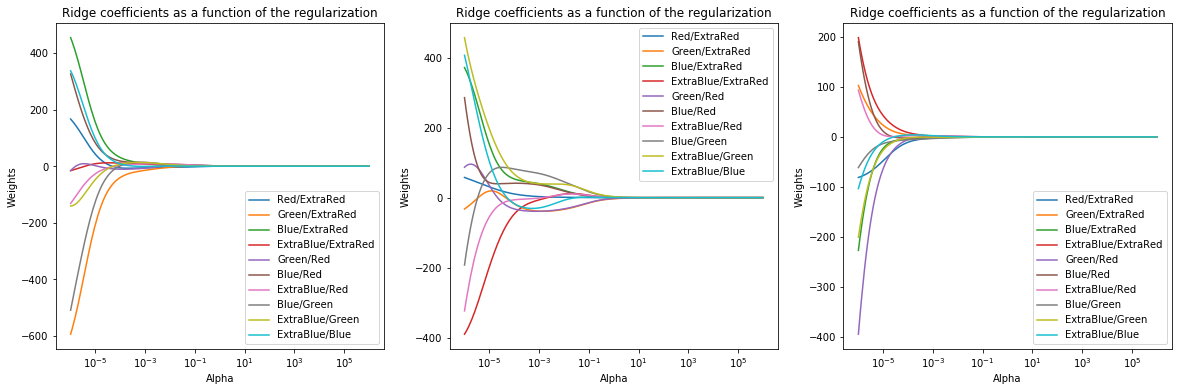

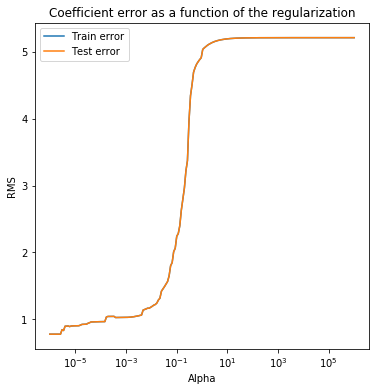

In [121]:
alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = mgp.my_2IterationsModel(linear_model.Ridge, [6,23], ModelsArguments={'alpha':a})
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False))

coefs0 = [Outputs[i][1]['Coefs'][0] for i in range(len(alphas))]
coefs1 = [Outputs[i][1]['Coefs'][1] for i in range(len(alphas))]
coefs2 = [Outputs[i][1]['Coefs'][2] for i in range(len(alphas))]

RMS = [Outputs[i][1]['MAE'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_MAE'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))

ax[0].plot(alphas, coefs0)
ax[1].plot(alphas, coefs1)
ax[2].plot(alphas, coefs2)
[ax[i].set_xscale('log') for i in range(3)]
[ax[i].set_xlabel('Alpha')for i in range(3)]
[ax[i].set_ylabel('Weights')for i in range(3)]
[ax[i].set_title('Ridge coefficients as a function of the regularization')for i in range(3)]
[ax[i].axis('tight')for i in range(3)]
[ax[i].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )for i in range(3)]
fig.show

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(alphas, tr_RMS, label='Train error')
ax.plot(alphas, RMS, label='Test error')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMS')
ax.set_title('Coefficient error as a function of the regularization')
ax.axis('tight')


print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

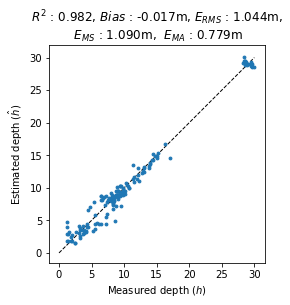

In [122]:
ModArg = {'alpha': alphas[np.argmax(R2_scores)]}
lr = mgp.my_2IterationsModel(linear_model.Ridge, [6,23], ModelsArguments=ModArg )
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

# Multi-linear : Lasso Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



Best RMS : 2.345 with alpha = exp(-6.00)
Best R2 : 0.910 with alpha = exp(-6.00)



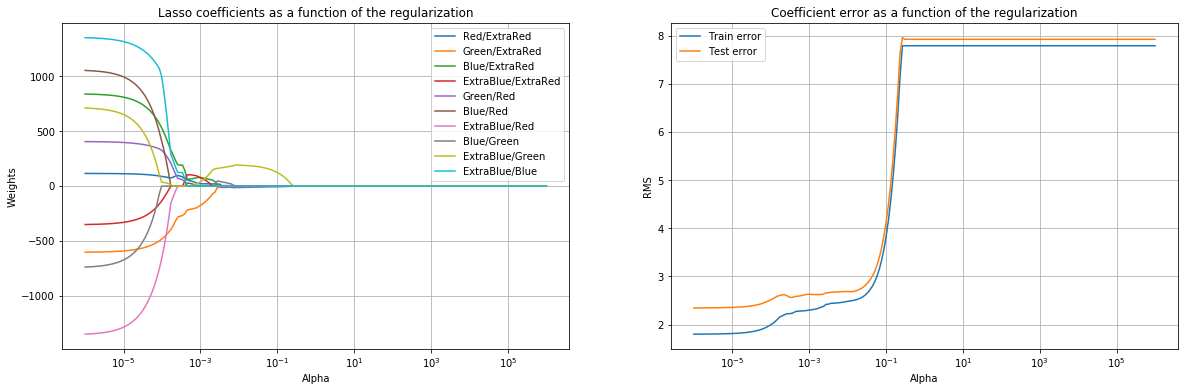

In [30]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Lasso(alpha=a, max_iter=10000)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[0].grid()
ax[1].plot(alphas, tr_RMS, label='Train error')
ax[1].plot(alphas, RMS, label='Test error')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



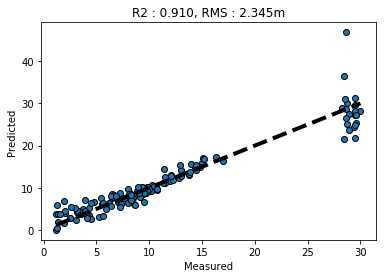

In [31]:
a = alphas[np.argmin(RMS)]
lr = linear_model.Lasso(alpha=a, max_iter=10000)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

# 2 Iterations Multi-linear : Lasso Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



Best RMS : 1.415 with alpha = exp(-5.94)
Best R2 : 0.967 with alpha = exp(-5.94)



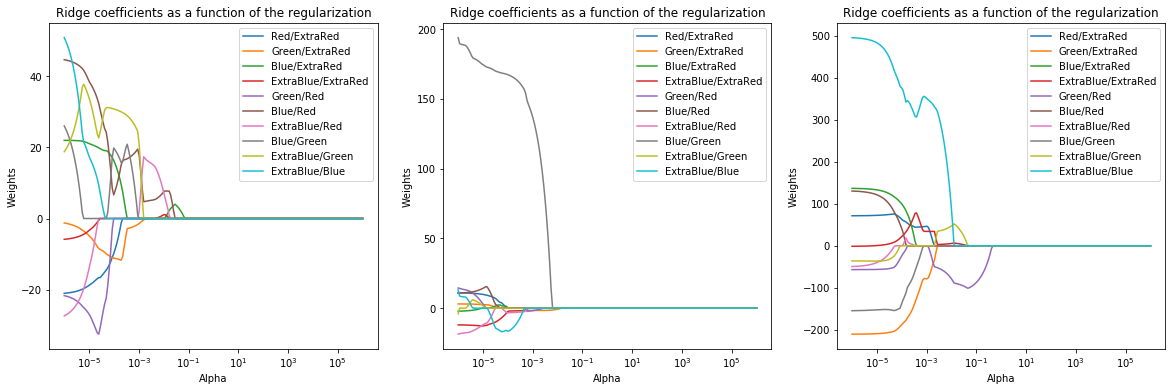

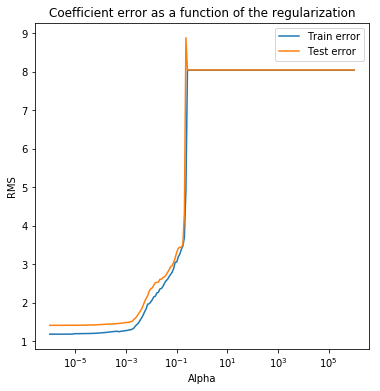

In [32]:
alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = mgp.my_2IterationsModel(linear_model.Lasso, [6,12], ModelsArguments={'alpha':a, 'max_iter':1000})
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

coefs0 = [Outputs[i][1]['Coefs'][0] for i in range(len(alphas))]
coefs1 = [Outputs[i][1]['Coefs'][1] for i in range(len(alphas))]
coefs2 = [Outputs[i][1]['Coefs'][2] for i in range(len(alphas))]

RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))

ax[0].plot(alphas, coefs0)
ax[1].plot(alphas, coefs1)
ax[2].plot(alphas, coefs2)
[ax[i].set_xscale('log') for i in range(3)]
[ax[i].set_xlabel('Alpha')for i in range(3)]
[ax[i].set_ylabel('Weights')for i in range(3)]
[ax[i].set_title('Ridge coefficients as a function of the regularization')for i in range(3)]
[ax[i].axis('tight')for i in range(3)]
[ax[i].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )for i in range(3)]
fig.show

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(alphas, tr_RMS, label='Train error')
ax.plot(alphas, RMS, label='Test error')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMS')
ax.set_title('Coefficient error as a function of the regularization')
ax.axis('tight')


print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



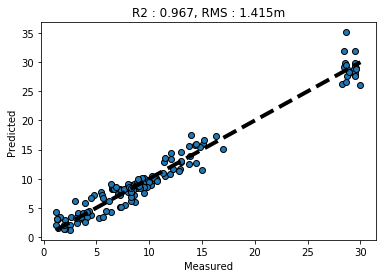

In [33]:
ModArg = {'alpha': alphas[np.argmin(RMS)], 'max_iter':1000}
lr = mgp.my_2IterationsModel(linear_model.Lasso, [6,12], ModelsArguments=ModArg )
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

# Huber Regression

In [34]:
SizeE, SizeA = 40, 200
epsilons = np.linspace(1.01, 1.40, SizeE)
alphas = np.logspace(-7, 5, SizeA)
RMS = np.full((SizeE,SizeA), np.nan, np.float)
R2_scores = np.full((SizeE,SizeA), np.nan, np.float)
coefs = np.full((SizeE,SizeA,x.shape[1]), np.nan, np.float)

Outputs = []

for ie, e in enumerate(epsilons):
    Outputs.append([])
    for ia, a in enumerate(alphas):
        lr = linear_model.HuberRegressor(alpha=a, epsilon=e, fit_intercept=True, max_iter=1000)
        Outputs[ie].append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))
    RMS[ie,:] = np.asarray([Outputs[ie][i][1]['RMS'] for i in range(len(alphas))])
    R2_scores[ie,:] = np.asarray([Outputs[ie][i][1]['R2_score'] for i in range(len(alphas))])
    coefs[ie,:,:] = np.asarray([Outputs[ie][i][1]['Coefs'] for i in range(len(alphas))])

bestE_R2, bestA_R2 = np.where(np.max(R2_scores)==R2_scores)
bestE_RMS, bestA_RMS = np.where(np.min(RMS)==RMS)

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f}), epsilons = {2:1.2f}\nBest R2 : {3:.3f} with alpha = exp({4:1.2f}), epsilons = {5:1.2f}\n'.format(
RMS[bestE_RMS, bestA_RMS][0], np.log10(alphas[bestA_RMS][0]), epsilons[bestE_RMS][0], 
R2_scores[bestE_R2, bestA_R2][0], np.log10(alphas[bestA_R2][0]), epsilons[bestE_R2][0]))

KeyboardInterrupt: 

In [ ]:
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, [coefs[bestE_R2,i,:].reshape(-1,) for i in range(len(alphas))])
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[0].grid()
ax[1].plot(alphas, RMS[bestE_R2,:].T)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

In [ ]:

lr = mgp.my_2IterationsModel(linear_model.HuberRegressor, [5.5, 12], ModelsArguments={'alpha':alphas[bestA_R2], 'epsilon':epsilons[bestE_R2], 'max_iter':10000})
Outputs.append(my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':100, 'shuffle':False}))

# Restore descriptors data

In [123]:
# Load Data at reduce backup size
npzfile = np.load(RatioPath[RatiosId])
Xc = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, Xc.shape[2]), np.nan) # Final array of optical data at Raster size 

# Translation of the data at the suitable dimension
X= Xc
del Xc

data_x = X[ClassifIndex, :] # Extract descriptor
del X # Free memory
data_x.shape

(2375098, 10)

# Predict depth of unknown pixels

In [124]:
# Look for Invalid values in descriptors matrix
NanIndex = np.sum(np.asarray([np.isnan(data_x[:,i]) for i in range(data_x.shape[1])]).T,axis=1)>0 
print('Nombre de pixels manquant: ', np.sum(NanIndex))
# Do prediction
modelUsed = Outputs[-1][1]['Model'] # recover the last trained model
Bathy = np.full((data_x.shape[0],), np.nan)
Bathy[~NanIndex] = modelUsed.predict(data_x[~NanIndex])# predict valid pixel

Nombre de pixels manquant:  663644


# Set predictions in raster dimension and Correct predictions from Tide

In [125]:
# Set predictions in raster dimension
BathyMap = np.full((RasterHeight, RasterWidth), np.nan)
BathyMap[ClassifIndex] = Bathy
del Bathy
TideCorrected = False

# Correct predictions from Tide
if not TideCorrected:
    BathyMap = BathyMap - TideHeight
    TideCorrected = True

# Visualize predictions on Image tide level

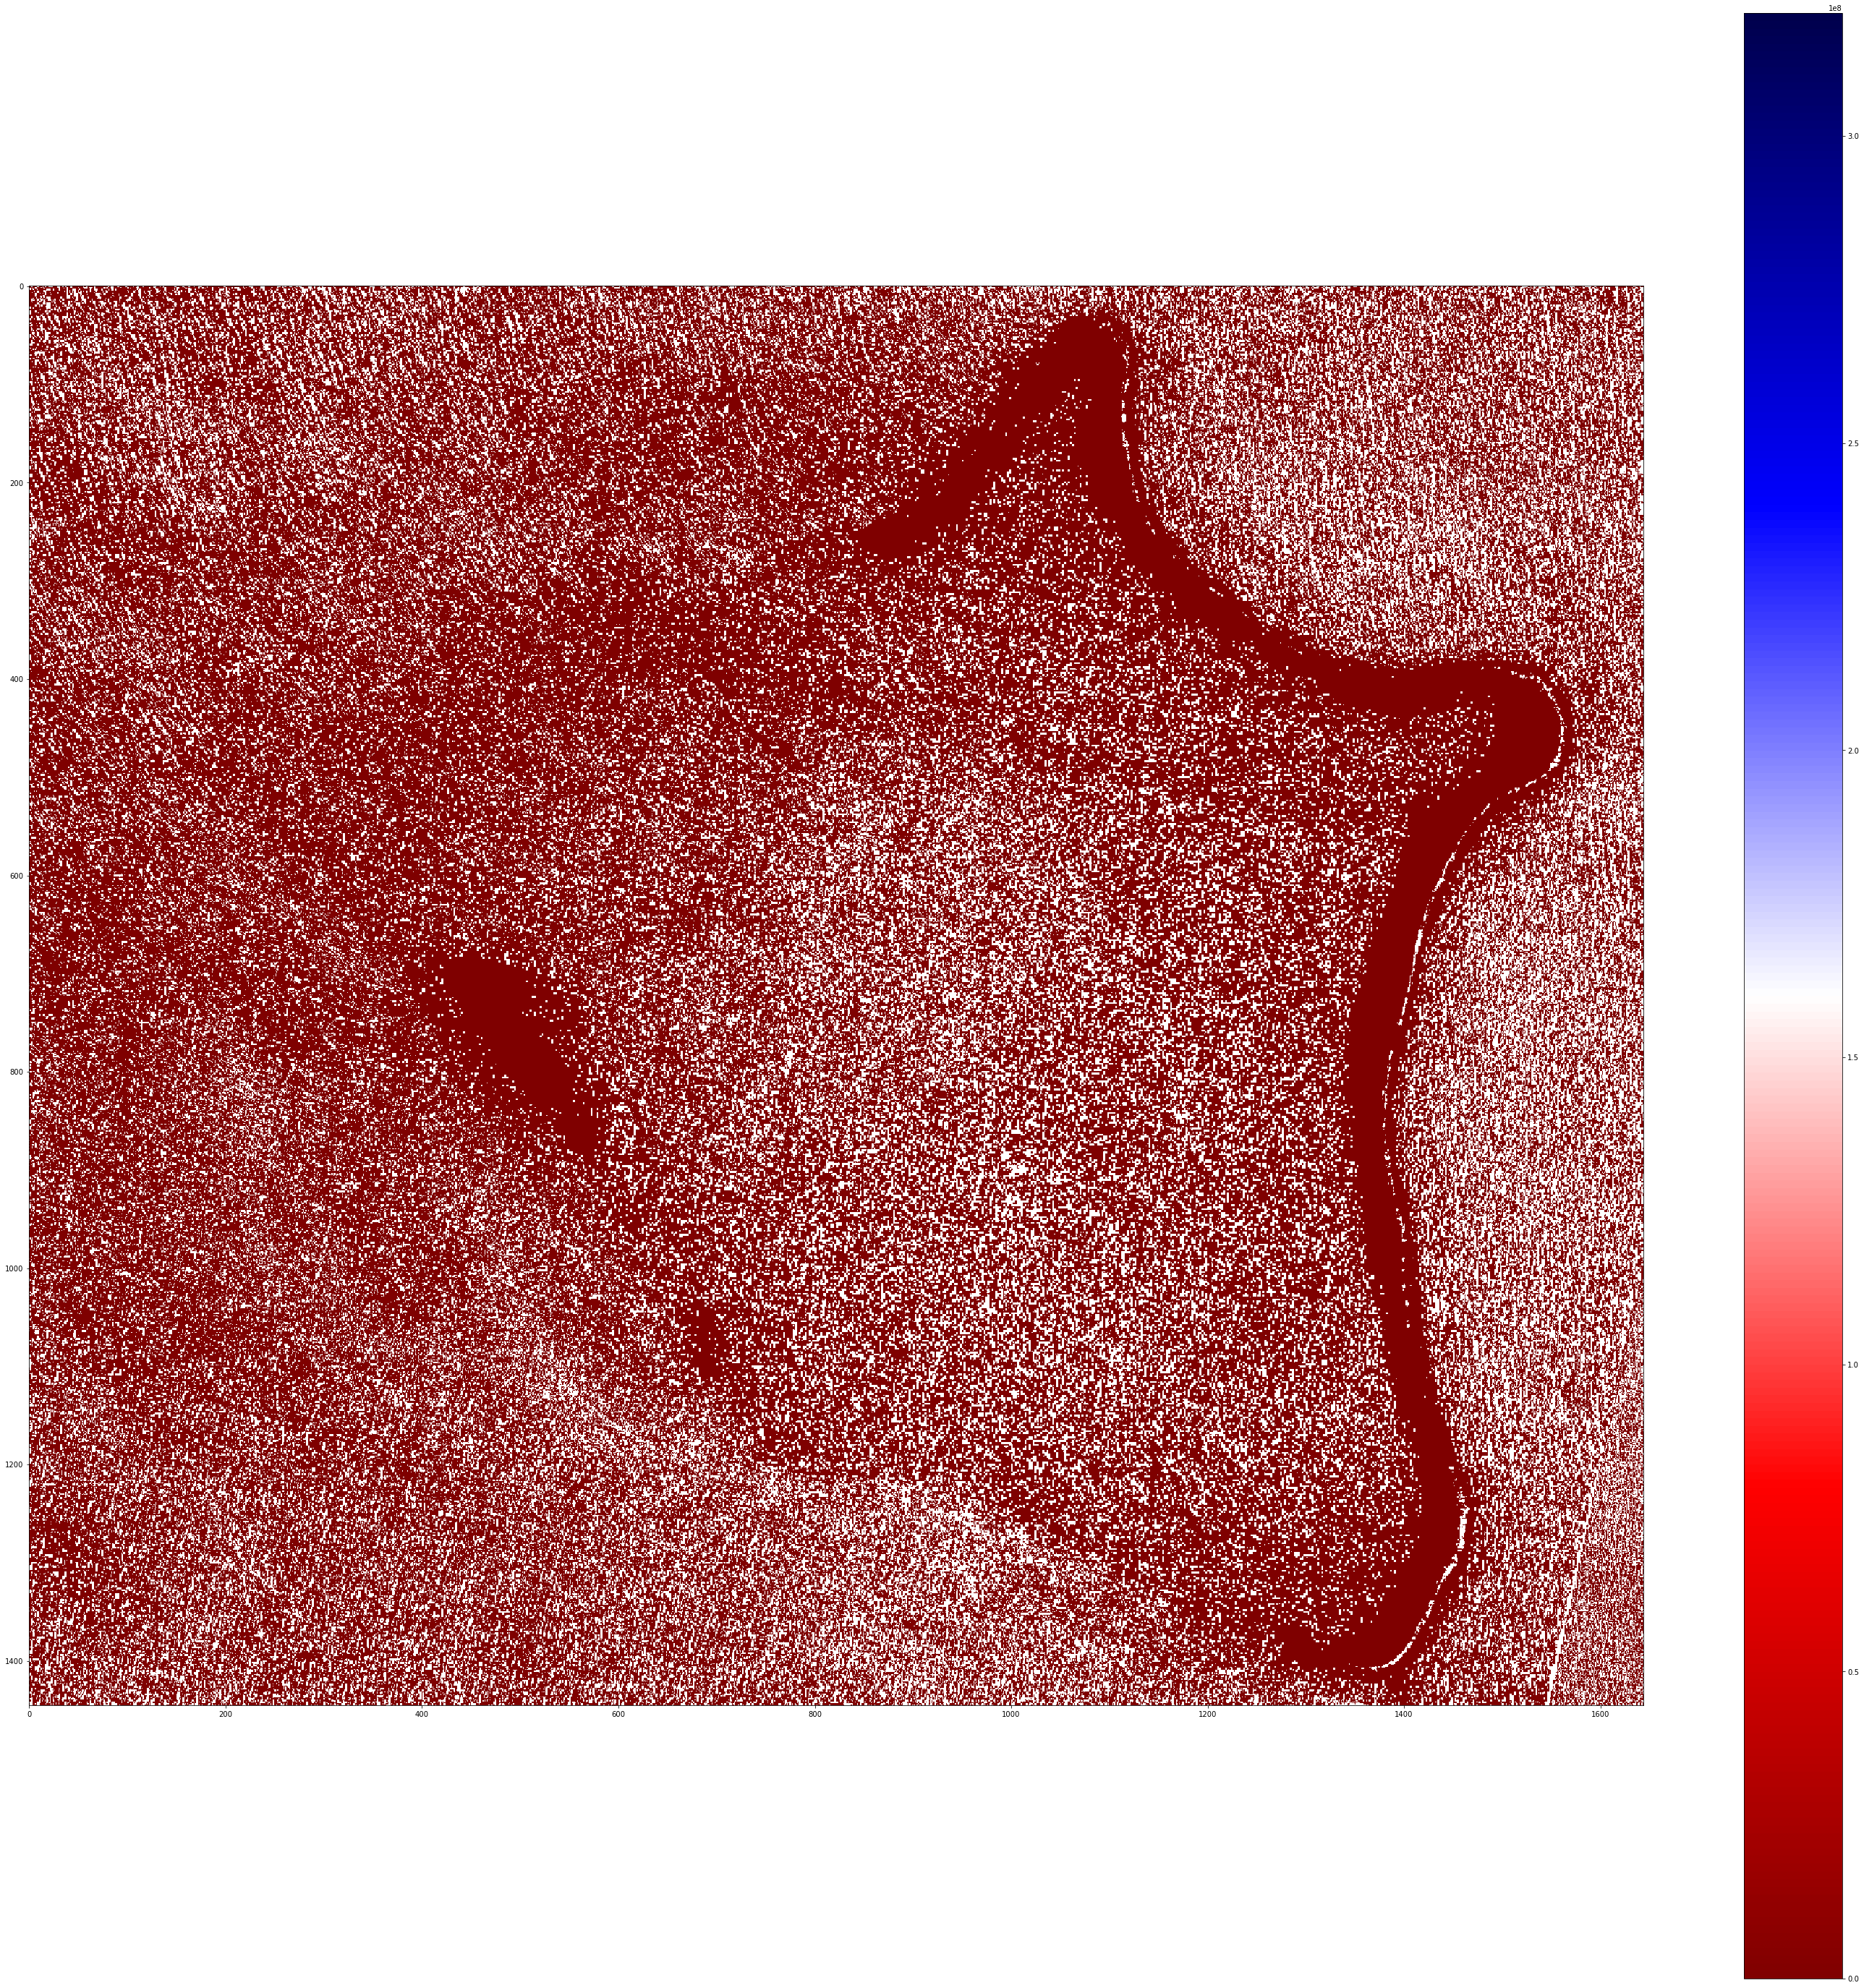

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(BathyMap,cmap='seismic_r')
plt.colorbar()

# Store Metadata in dictionnary and Compute interpolated deviation map

In [126]:
# Store Metadata in dictionnary
Metadata = {}
#============================================================================
ImageName = 'S2A_MSIL1C_20170929T231851_N0205_R001_T58KDE_20170929T231932'
Metadata['ImageName'] = ImageName
#============================================================================

if type(modelUsed.coef_[0])==np.ndarray:  
    MatrixCoef = np.asarray(modelUsed.coef_)
    MatrixInterc = np.asarray(modelUsed.intercept_)
    #=============================================================== modelUsed.intercept_ et modelUsed.coef_ :  les premières dimensions doivent correspondre au nombre de modèles en deuxième iteration
    Metadata['Model_coefficients'] = str({str(RatiosKeys[c][0])+'/'+str(RatiosKeys[c][1]):'{0:.16f}, {1:.16f}, {2:.16f}'.format(modelUsed.coef_[0][c], modelUsed.coef_[1][c], modelUsed.coef_[2][c])for c in range(modelUsed.coef_[0].shape[0])})
    Metadata['Model_intercepts'] = '{0:.16f}, {1:.16f}, {2:.16f}'.format(modelUsed.intercept_[0], modelUsed.intercept_[1], modelUsed.intercept_[2])
    #=============================================================== modelUsed.intercept_ et modelUsed.coef_ :  les premières dimensions doivent correspondre au nombre de modèles en deuxième iteration
else:
    Metadata['Model_coefficients'] = str({str(RatiosKeys[i][0])+'/'+str(RatiosKeys[i][1]):'{0:.16f}'.format(a) for i, a in enumerate(modelUsed.coef_)})
    Metadata['Model_intercepts'] = '{0:.16f}'.format(modelUsed.intercept_)
    
for a in Outputs[-1][1].keys(): 
    if not (a=='Intercept' or a=='Coefs'):
        Metadata[a] = str(Outputs[-1][1][a])

# Compute interpolated deviation map
InterpDevMethode = "nearest"
Ecart = modelUsed.predict(x) - y
DeviationMap = mgp.GetInnerInterp(Ecart, ind, methode = InterpDevMethode)
#==========================================================================================
Metadata['Description'] = 'Band1: Depth prediction at zero hydrographic level(de la Station d''Ouvea, donc presence d''un biais systematique), Band2: Interpolated deviation map (prediction - true) with '+InterpDevMethode+' method' 
#==========================================================================================
Metadata['Description de la Zone de Calibration'] = Roidescription[CalibZoIndex]

BathyRaster = np.stack((BathyMap,DeviationMap), axis=2)
BathyRaster.shape
del BathyMap, DeviationMap

# Write Geotiff raster

In [127]:
#===============================================================
BathyFolder = '../../Resultats/Bathymetries/S2A_MSIL1C_20170929T231851_N0205_R001_T58KDE_20170929T231932/'
#===============================================================
TempoFolder = '/vsimem/'
filename = 'Stumpf_NoClass_' + str(modelUsed).split("(")[0] + \
            "_GlintProcess_" + RatioType[RatiosId]+ \
            "_PixInterp_" + PixMethod[PixMethodIndex] + \
            "_CoverPixRatio" + '{0:.0f}%_'.format(CoverThreshold*100)+ \
            'CalibZone_'+ RoiPathName[CalibZoIndex][:-4]+ \
            ".tif"
fTempName = TempoFolder + filename
fname = BathyFolder + filename

mgp.write_raster2(fname, BathyRaster, GT_ds, proj, DriverName="GTiff", formatMem=gdal.GDT_Float32,Metadata=Metadata, Offset=None)
#response = gdal.Translate(destName=fname, srcDS=fTempName, srcWin=(0, 5500, 8500, 5480))
#if response is None:
#    print('fail')

In [91]:
modelUsed

2Iters_Classes_[6, 23, inf]_LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)